# Light on Math Machine Learning: Word2vec

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import collections
import math
import numpy as np
import os
import tensorflow as tf
from matplotlib import pylab
from sklearn.manifold import TSNE
import operator # sorting items in dictionary by value
from math import ceil


c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Reading data
Here we have a file called `pets.txt` which is an extracted and slightly edited (e.g. removing reference numbers) Wikipedia article found [here](https://en.wikipedia.org/wiki/Pet). We will be reading that file, doing simple preprocessing and tokenizing the text into words.

In [33]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    
    return text

def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""

  with open(filename,'r') as f:
    data = []
    file_string = f.read()
    file_string = preprocess_text(file_string)
    file_string = file_string.split(' ')
    data.extend(file_string)
  return data
  
words = read_data('pets.txt')
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Data size 24003
Example words (start):  ['', 'a', 'tabby', 'cat', 'and', 'a', 'mixed', 'molosser', 'dog', 'a']
Example words (end):  ['be', 'injured', 'or', 'killed', 'by', 'a', 'high', 'fall', '282', '']


In [35]:
vocabulary_size = 0
def build_dataset(words):
  global vocabulary_size

  count = [['UNK', -1]]
  # Gets words sorted by frequency
  count.extend(collections.Counter(words).most_common())
  dictionary = dict()

  # Create an ID for each unique word
  for word, c in count:
    if c<10:
        continue
    dictionary[word] = len(dictionary)
    vocabulary_size += 1
    
  data = list()
  unk_count = 0
  
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  
      unk_count = unk_count + 1
    data.append(index)
    
  count[0][1] = unk_count
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('Vocabulary size: ',vocabulary_size)

Most common words (+UNK) [['UNK', 9628], ('the', 1142), ('of', 765), ('and', 731), ('to', 569)]
Sample data [7, 5, 0, 18, 2, 5, 0, 0, 14, 5]
Vocabulary size:  311


## Generating data
Here we generate a batch of data as explained earlier in the [blog post](http://www.thushv.com/natural_language_processing/light-on-math-machine-learning-intuitive-guide-to-understanding-word2vec). 

In [51]:
data_index = 0

def generate_batch(batch_size, window_size):
  global data_index 
    
  # two numpy arras to hold target words (batch)
  # and context words (labels)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
  # span defines the total window size
  span = 2 * window_size + 1 
    
  # The buffer holds the data contained within the span
  queue = collections.deque(maxlen=span)
  
  # Fill the buffer and update the data_index
  for _ in range(span):
    queue.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  

  for i in range(batch_size // (2*window_size)):
    k=0
    # Avoid the target word itself as a prediction
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * (2*window_size) + k] = queue[window_size]
      labels[i * (2*window_size) + k, 0] = queue[j]
      k += 1 
    
    # Everytime we read num_samples data points, update the queue
    queue.append(data[data_index])
    
    # If end is reached, circle back to the beginning
    data_index = (data_index + np.random.randint(window_size)) % len(data)
    
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

data_index = 0
batch, labels = generate_batch(batch_size=8, window_size=2)
print('\nwith window_size = %d:' %2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['', 'a', 'the', 'cat', 'and', 'a', 'the', 'the']

with window_size = 2:
    batch: ['the', 'the', 'the', 'the', 'cat', 'cat', 'cat', 'cat']
    labels: ['', 'a', 'cat', 'and', 'a', 'the', 'and', 'a']


## Defining the model

Here we define the followings:
* Hyperparameters (e.g. `batch_size`)
* Input and output placeholders 
* Model parameter: the embedding layer
* Model parameter: the neural network (a softmax layer)
* Loss of the model 
* Optimizer for the loss function

In [52]:
batch_size = 128 
embedding_size = 64 
window_size = 4 

num_sampled = 32 # Number of negative examples to sample.

tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

################################################
#            Model variables                   #
################################################

# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Neural network weights and biases
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.1 / math.sqrt(embedding_size))
)
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],-0.01,0.01))

# Look up embeddings for a batch of inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)
#embed = tf.nn.dropout(embed, keep_prob=0.8)
################################################
#            Computes loss                     #
################################################
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        weights=softmax_weights, biases=softmax_biases, inputs=embed,
        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
)

################################################
#            Optimization                      #
################################################
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

################################################
#            For evaluation                    #
################################################
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm

## Running skip-gram
We optimize the define model for a pre-defined number of steps and save the learnt embeddings to a Python variable

In [54]:
num_steps = 250001

session = tf.InteractiveSession()

# Initialize the variables in the graph
tf.global_variables_initializer().run()
print('Initialized')
average_loss = 0

for step in range(num_steps):

    # Generate a single batch of data
    batch_data, batch_labels = generate_batch(
      batch_size, window_size)

    # Optimize the embedding layer and neural network
    # compute loss
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    # Update the average loss variable
    average_loss += l

    if (step+1) % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 5000

      print('Average loss at step %d: %f' % (step+1, average_loss))
      average_loss = 0

sg_embeddings = normalized_embeddings.eval()
session.close()


c:\users\thushan\documents\python_virtualenvs\tensorflow_venv\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 5000: 2.733738
Average loss at step 10000: 2.506902
Average loss at step 15000: 2.487006
Average loss at step 20000: 2.465725
Average loss at step 25000: 2.456681
Average loss at step 30000: 2.461687
Average loss at step 35000: 2.449213
Average loss at step 40000: 2.449819
Average loss at step 45000: 2.438913
Average loss at step 50000: 2.437386
Average loss at step 55000: 2.432998
Average loss at step 60000: 2.429778
Average loss at step 65000: 2.435080
Average loss at step 70000: 2.429206
Average loss at step 75000: 2.430723
Average loss at step 80000: 2.428075
Average loss at step 85000: 2.427969
Average loss at step 90000: 2.425614
Average loss at step 95000: 2.422952
Average loss at step 100000: 2.424210
Average loss at step 105000: 2.424904
Average loss at step 110000: 2.426657
Average loss at step 115000: 2.426729
Average loss at step 120000: 2.413245
Average loss at step 125000: 2.419772
Average loss at step 130000: 2.422087
Average loss at step

## Visualizing word vectors
Here we visualize the word vectors by means of the t-SNE dimensionality reduction technique.

In [ ]:
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(sg_embeddings)

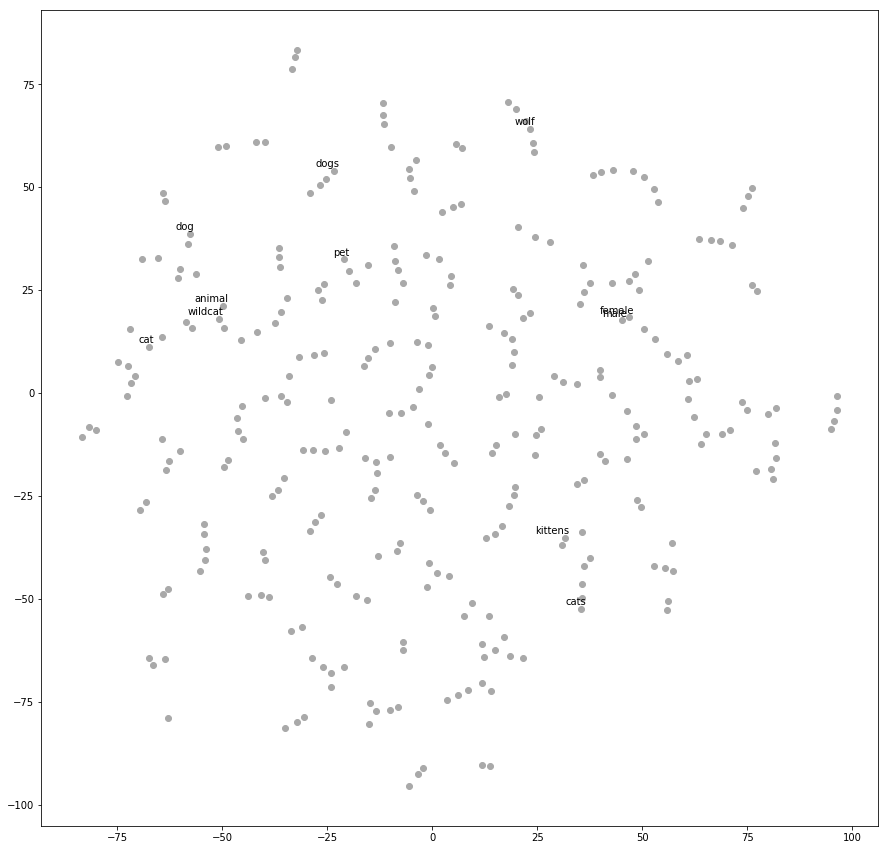

In [60]:
selected_words = ['feline','cat','dog','canary','male','female','animal','pet','wolf','cats','dogs','wildcat','kittens']

words = [reverse_dictionary[i] for i in np.arange(vocabulary_size)]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y, c='darkgray')   
    if label in selected_words:
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)
        
pylab.show()